<a href="https://colab.research.google.com/github/Mudit0110/Stress-Detection-System/blob/main/data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# prompt: Now give me code to import from google drive

import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/df_aug.csv')
df.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [ ]:
df.shape

(11117, 2)

In [ ]:
# Exact duplicates
print("Exact duplicates:", df.duplicated().sum())

# Duplicate texts only
print("Duplicate texts only:", df['text'].duplicated().sum())

Exact duplicates: 745
Duplicate texts only: 754


In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(10372, 2)

In [ ]:
# Empty or null
print("Empty or null texts:", df['text'].isnull().sum())

# Very short texts (less than 3 words)
short_texts = df[df['text'].str.split().str.len() < 3]
print("Very short texts (<3 words):", len(short_texts))

Empty or null texts: 0
Very short texts (<3 words): 2


In [ ]:
df = df[df['text'].notnull() & (df['text'].str.split().str.len() >= 3)]

In [ ]:
df.shape

(10370, 2)

In [ ]:
# View samples where same text appears with different labels (label noise)
conflicts = df.groupby('text')['label'].nunique()
conflicts = conflicts[conflicts > 1]
print("Conflicting labels (same text, different label):", len(conflicts))

Conflicting labels (same text, different label): 8


In [ ]:
df = df[~df['text'].isin(df.groupby('text')['label'].nunique().reset_index().query('label > 1')['text'])]

In [ ]:
df.shape

(10354, 2)

In [ ]:
df.sample(10)

,text,label
10118,I’m having a difficult time coping with how my...,1
3283,So let's forget all about my biological father...,0
7058,Since this happened during a pivotal time in h...,0
9289,"I met Zach and James , we were roughly the sam...",0
8246,But what do I know? I keep reassuring myself t...,1
6702,Please leave a comment below or DM me if you'r...,0
9591,But I mean does it really matter? I didn't kno...,1
5318,"WARNING GRAPHIC! url> That same day, my accide...",0
3656,I've been dating my GF for about 10 months and...,0
3601,I wondered if anyone else had a similar place ...,1


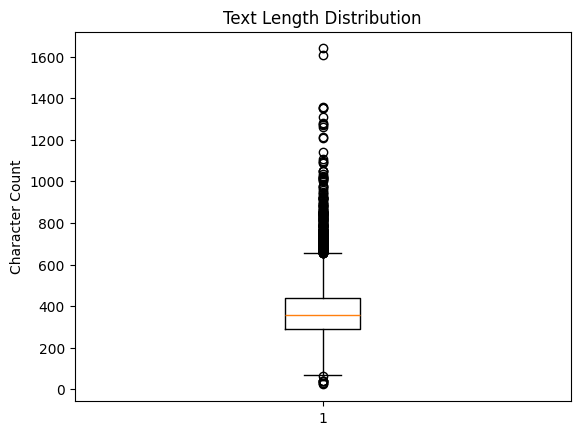

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `df` with 'text' and 'label' columns
df['text_length'] = df['text'].apply(len)

# Box plot to detect length outliers
plt.boxplot(df['text_length'])
plt.title("Text Length Distribution")
plt.ylabel("Character Count")
plt.show()

# You can filter long/short texts like this:
outlier_texts = df[(df['text_length'] > df['text_length'].quantile(0.95)) |
                   (df['text_length'] < df['text_length'].quantile(0.05))]

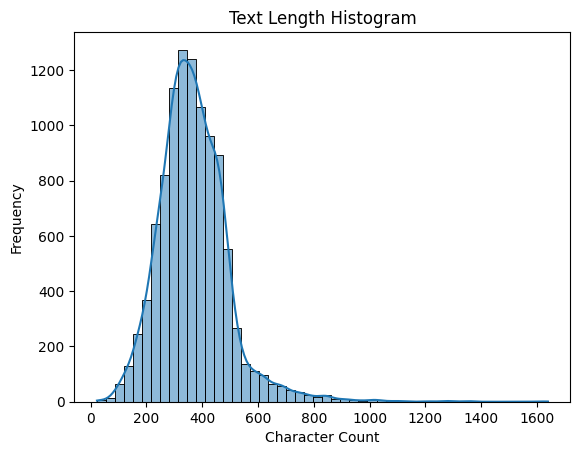

In [ ]:
import seaborn as sns

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Text Length Histogram")
plt.xlabel("Character Count")
plt.ylabel("Frequency")
plt.show()

In [ ]:
df['text_length'] = df['text'].apply(len)

In [ ]:
Q1 = df['text_length'].quantile(0.25)
Q3 = df['text_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['text_length'] < lower_bound) | (df['text_length'] > upper_bound)]
print(f"Total outliers: {len(outliers)}")

Total outliers: 300


In [ ]:
outliers[['text', 'text_length', 'label']].head(10)

,text,text_length,label
2,My mom then hit me with the newspaper and it s...,847,1
3,"until i met my new boyfriend, he is amazing, h...",1277,1
19,"We had plans to move in together, a fancy $1,8...",681,0
52,All of these things I think contributed to thi...,784,0
55,She was already against smoking weed after col...,946,1
56,During the pregnancy and after the (traumatic)...,751,0
64,"In class, im always on edge, i cant focus on o...",696,1
92,"(Hurt the ego, but whatever, I guess you're no...",1050,1
101,Trauma survivors often don’t need more awarene...,669,0
102,"These weren't the only punishments, though. So...",788,0


In [ ]:
df_no_outliers = df[(df['text_length'] >= lower_bound) & (df['text_length'] <= upper_bound)]

In [ ]:
df_no_outliers.shape

(10054, 3)

In [ ]:
print(outliers['label'].value_counts(normalize=True))

label
1    0.606667
0    0.393333
Name: proportion, dtype: float64


In [ ]:
df_no_outliers.to_csv('/content/drive/MyDrive/final_df_aug.csv', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
import transformers
from transformers import Trainer, TrainingArguments
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
df.isnull().sum()

,0
text,0
label,0
text_length,0


In [ ]:
!pip install nlpaug
!pip install nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 11.2 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [ ]:
import nlpaug.augmenter.word as naw
import pandas as pd

In [ ]:
# from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
# import torch
# import pandas as pd
# from tqdm import tqdm

# # Load T5 Paraphrasing Model
# model_name = "Vamsi/T5_Paraphrase_Paws"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = model.to(device)
# model = model.half()  # Mixed precision for faster inference

# def paraphrase_batch(texts, batch_size=16):
#     paraphrased_texts = []
#     for i in tqdm(range(0, len(texts), batch_size), desc="Paraphrasing"):
#         batch = texts[i:i+batch_size]
#         input_texts = [f"paraphrase: {text} </s>" for text in batch]

#         encoding = tokenizer(
#             input_texts,
#             padding="max_length",
#             truncation=True,
#             max_length=256,
#             return_tensors="pt"
#         ).to(device)

#         # Important: .half() only on model, NOT on inputs
#         with torch.no_grad():
#             outputs = model.generate(
#                 **encoding,
#                 max_length=256,
#                 num_beams=3,  # reduced from 5 to 3 to speed up
#                 num_return_sequences=1,
#                 no_repeat_ngram_size=2,
#                 early_stopping=True
#             )

#         decoded = tokenizer.batch_decode(outputs, skip_special_tokens=True)
#         paraphrased_texts.extend(decoded)
#     return paraphrased_texts

# # Apply on your df
# texts = df['text'].tolist()
# labels = df['label'].tolist()

# paraphrased = paraphrase_batch(texts, batch_size=16)

# augmented_texts = []
# augmented_labels = []

# for orig_text, para_text, label in zip(texts, paraphrased, labels):
#     if para_text.strip().lower() != orig_text.strip().lower():
#         augmented_texts.append(para_text)
#         augmented_labels.append(label)

# # Create augmented DataFrame
# df_augmented = pd.DataFrame({'text': augmented_texts, 'label': augmented_labels})

# # Combine with original
# df_combined = pd.concat([df, df_augmented]).reset_index(drop=True)

# print("Original samples:", len(df))
# print("Augmented samples:", len(df_augmented))
# print("Total after augmentation:", len(df_combined))

In [ ]:
print("Original dataset size:", len(df))
print("Augmented dataset size:", len(df_combined))

Original dataset size: 5664
Augmented dataset size: 11117


In [ ]:
df_combined.shape

(11117, 2)

In [ ]:
df_combined.head()

,text,label
0,"He said he had not felt that way before, sugge...",1
1,"Hey there r/assistance, Not sure if this is th...",0
2,My mom then hit me with the newspaper and it s...,1
3,"until i met my new boyfriend, he is amazing, h...",1
4,October is Domestic Violence Awareness Month a...,1


In [ ]:
# prompt: I want to save df_combined in google drive

df_combined.to_csv('/content/drive/MyDrive/df_aug.csv', index=False)

NameError: name 'df_combined' is not defined

In [ ]:
# Split dataset
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_no_outliers['text'].tolist(), df_no_outliers['label'].tolist(), test_size=0.2, random_state=42
)

In [ ]:
# Convert to HuggingFace Dataset format
train_ds = Dataset.from_dict({'text': train_texts, 'label': train_labels})
test_ds = Dataset.from_dict({'text': test_texts, 'label': test_labels})

In [ ]:
# 🔧 Define model options
model_options = {
    "1": "distilbert-base-uncased",
    "2": "bert-base-uncased",
    "3": "roberta-base",
    "4": "distilroberta-base",
    "5": "emilyalsentzer/Bio_ClinicalBERT"
}

# 📋 Show menu to user
print("Select a pre-trained model:")
for key, value in model_options.items():
    print(f"{key}. {value}")

# 🎯 Get user's choice
choice = input("Enter the number corresponding to the model you want to use: ")
model_name = model_options.get(choice)

# 🛑 Handle invalid input
if model_name is None:
    print("Invalid choice. Using default: distilbert-base-uncased")
    model_name = "distilbert-base-uncased"

print(f"\n✅ You selected: {model_name}")

Select a pre-trained model:
1. distilbert-base-uncased
2. bert-base-uncased
3. roberta-base
4. distilroberta-base
5. emilyalsentzer/Bio_ClinicalBERT
Enter the number corresponding to the model you want to use: 2

✅ You selected: bert-base-uncased


In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
def tokenize(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8043 [00:00<?, ? examples/s]

Map:   0%|          | 0/2011 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

In [ ]:
from transformers import EarlyStoppingCallback

In [ ]:
# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    load_best_model_at_end=True,
    report_to="none",
    logging_steps=10,  # log every 10 steps
    save_steps=500
)



trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

<ipython-input-39-1274792000>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.076000,0.196592,0.969170,0.955237,0.988879,0.971767
2,0.018600,0.144156,0.980109,0.973564,0.989805,0.981618


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.371900,0.177551,0.945798,0.927690,0.974977,0.950746


TrainOutput(global_step=1006, training_loss=0.047323302767622775, metrics={'train_runtime': 758.5976, 'train_samples_per_second': 21.205, 'train_steps_per_second': 1.326, 'total_flos': 2116202218260480.0, 'train_loss': 0.047323302767622775, 'epoch': 2.0})

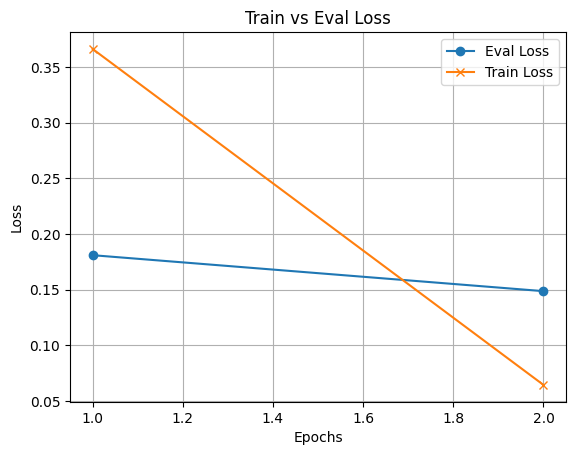

In [ ]:
# Get training and evaluation logs
import matplotlib.pyplot as plt # Import matplotlib for plotting
train_logs = trainer.state.log_history
train_loss = [log["loss"] for log in train_logs if "loss" in log]
eval_loss = [log["eval_loss"] for log in train_logs if "eval_loss" in log]
epochs = list(range(1, len(eval_loss)+1))

# Plot
plt.plot(epochs, eval_loss, label="Eval Loss", marker='o')
plt.plot(epochs, train_loss[:len(eval_loss)], label="Train Loss", marker='x')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Eval Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
results = trainer.evaluate()
print("Evaluation results:", results)

Evaluation results: {'eval_loss': 0.14405731856822968, 'eval_accuracy': 0.9686723023371457, 'eval_precision': 0.9560143626570916, 'eval_recall': 0.9870250231696015, 'eval_f1': 0.9712722298221614, 'eval_runtime': 13.5688, 'eval_samples_per_second': 148.208, 'eval_steps_per_second': 9.286, 'epoch': 2.0}


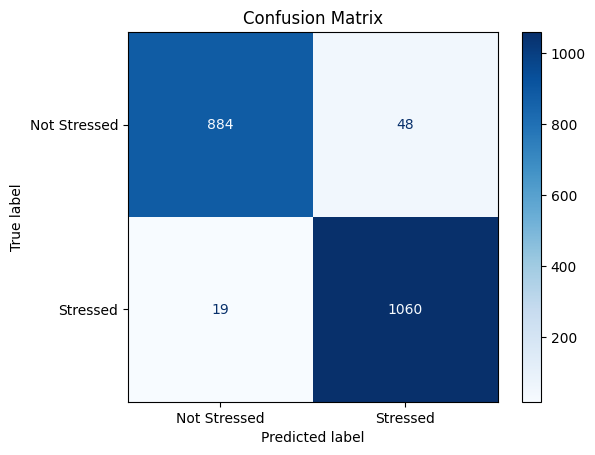

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get model predictions on the test dataset
predictions = trainer.predict(test_ds)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(labels, preds)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Stressed', 'Stressed'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Define a folder in your Google Drive
save_path = '/content/drive/My Drive/stress_model_distil-BERT'

# Save the model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"✅ Model saved to: {save_path}")

✅ Model saved to: /content/drive/My Drive/stress_model_distil-BERT
